In [1]:
#En este ejemplo utilizaremos la regresión logística regularizada para si los microchips de una planta de fabricacion
#pasa el test de calidad. Durante los tests de calidad los microchips pasan por varias pruebas para asegurar su correcto
#funcionamiento.
#Supongamos que eres el gerente del producto de la fábrica y tienes los resultados de algunso microchips para dos tipos
#de prueba. A partir de estas dos pruebas quisieras determinar si los microchips deberían ser aceptados o rechazados.
#Para ello se tienen datos históricos de resultados de pruebas anteriores, desde el cual vamos a construir el modelo logistico.


In [3]:
#Configuración de tamaño de gráficos
options(repr.plot.width=5, repr.plot.height=4, scipen = 999)

In [4]:
#Instalación y carga de paquetes necesarios
list.of.packages <- c('ggplot2')

new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "https://cran.r-project.org")

library(ggplot2)

In [5]:
#Carga de datos
microchips <- read.table(file = 'ex2data2.txt', header = TRUE, 
                        col.names = c('test1', 'test2', 'accepted'), sep = ",", dec = ".")

In [6]:
#Exploración de datos
head(microchips)
microchips$accepted <- factor(microchips$accepted, levels = c(1, 0), labels = c('Aceptado', 'Rechazado'))
str(microchips)

test1,test2,accepted
-0.092742,0.684940,1
-0.213710,0.692250,1
-0.375000,0.502190,1
-0.513250,0.465640,1
-0.524770,0.209800,1
-0.398040,0.034357,1


'data.frame':	117 obs. of  3 variables:
 $ test1   : num  -0.0927 -0.2137 -0.375 -0.5132 -0.5248 ...
 $ test2   : num  0.685 0.692 0.502 0.466 0.21 ...
 $ accepted: Factor w/ 2 levels "Aceptado","Rechazado": 1 1 1 1 1 1 1 1 1 1 ...


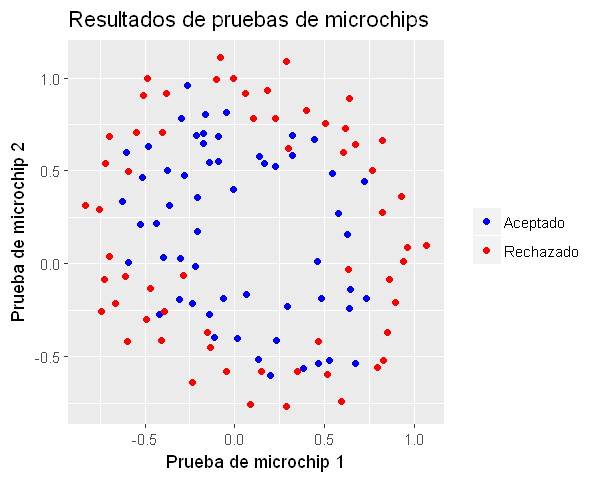

In [7]:
#Visualización de datos
ggplot(data = microchips, aes(x = test1, y = test2, col = accepted)) + geom_point() +
    labs(x = 'Prueba de microchip 1', y = 'Prueba de microchip 2') + ggtitle('Resultados de pruebas de microchips') +
    theme(legend.title=element_blank()) +
    scale_colour_manual(name='', values=c('Aceptado'='blue', 'Rechazado'='red'))

In [8]:
#A simple viste vemos que ambas clases no pueden ser separados a través de una linea recta, por lo tanto utilizar una 
#enfoque directo de la regresión lineal no sería conveniente.
#Por lo tanto tendremos que construir más atributos de entrada a partir de los dos que tenemos. Para ello usaremos
#términos polinómicos hasta el grado 6.

#Es decir, no solo tendremos x0, x1 y x2, sino que deberíamos tener: x0, x1, x2, x1*x2, x1*x2^2, x1^2*x2... x1^6 * x2^6.

#Una regresión logística con estas entradas tendrá una frontera entre clases mucho más compleja y se ajustará mucho
#mejor a los datos pero por otro lado es más susceptible a sobreajustarse, por lo tanto debemos REGULARIZAR.

In [44]:
#Preparamos los datos para la regresión
X <- microchips$test1
X <- cbind(X, microchips$test2)

y <- 2 - as.integer(microchips$accepted)

m <- nrow(X)
degree <- 6
lambda <- 5

#chequeamos las primeras 10 observaciones
head(X,10)
head(y,10)

X,
-0.092742,0.684940
-0.213710,0.692250
-0.375000,0.502190
-0.513250,0.465640
-0.524770,0.209800
-0.398040,0.034357
-0.305880,-0.192250
0.016705,-0.404240
0.131910,-0.513890
0.385370,-0.565060


[1] 1 1 1 1 1 1 1 1 1 1

In [45]:
#Creamos los nuevos términos polinómicos
agregarAtributos <- function(X1, X2) {
    
    out <- matrix(1,length(X1),1)
  
    for (i in 1:degree)
       for (j in 0:i)
         out <- cbind(out, (X1 ^ (i - j)) * (X2 ^ j))

    out
}
        
X <- agregarAtributos(X[,1], X[,2])

In [46]:
#Creamos la función sigmoidal
sigmoid <- function(z) {
  
  g <- 1 / (1 + exp(1) ^ (-z))
}

In [47]:
#Construimos la función de costo 

computeCost <- function(theta) {
    
    hyp <-  sigmoid(X %*% theta)
    
    J_noreg <- (-1 / m) * (t(y) %*% log(hyp) + (t((1 - y)) %*% log(1 - hyp)))
        
    theta[1] <- 0
    
    J_reg <- J_noreg + (lambda / (2 * m)) * sum(theta ^ 2)
    
    J_reg
    
}

In [48]:
#Inicializamos los parámetros theta
initial_theta <- numeric(ncol(X))

#Configuramos las opciones de optim
theta_optim <- optim(par = initial_theta, fn = computeCost)
theta <- theta_optim$par
J <-  theta_optim$value

#Valores optimos de theta
theta
#Costo final
J

[1]  0.4259776664  0.0048275096  0.1863816782 -0.7445682971 -0.0093921773
 [6] -0.2526198478  0.0029395496  0.0908358909  0.0723744799 -0.0437354590
[11] -0.3747708565  0.0998958788  0.0073144762  0.1459606744 -0.4450578547
[16]  0.1081367970  0.1434522096  0.1238186663  0.0002519284  0.0261125026
[21] -0.0755753313 -0.1083772618  0.2046876145  0.0767532288  0.2485288285
[26]  0.2565467164  0.0054338720 -0.2951521929

[1] 0.6490113

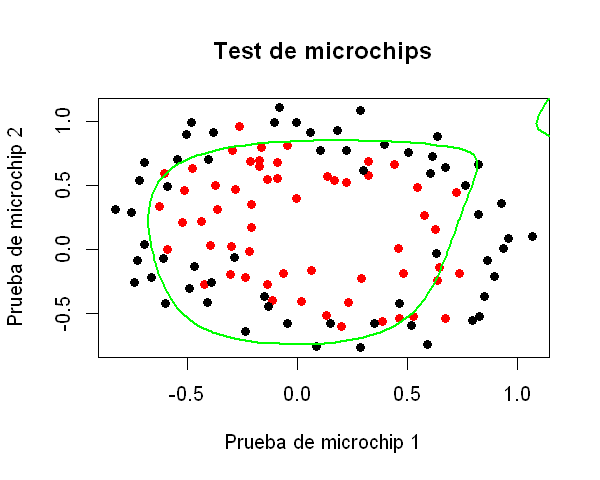

In [49]:
#Graficamos el limite entre ambas clases

#Graficamos los puntos
plot(X[,2], X[,3], col = factor(y), pch = 19, xlab = "Prueba de microchip 1", ylab = "Prueba de microchip 2",
    main = "Test de microchips")

# Creamos la grilla para dibujar el limite entre las clases
u <- seq(-1,1.5, length.out = 50)
v <- seq(-1,1.5, length.out = 50)
z <- matrix(0, length(u), length(v))

# Evaluamos z sobre la grilla de puntos
for (i in 1:length(u))
    for (j in 1:length(v))
      z[i,j] <- agregarAtributos(u[i], v[j]) %*% theta

#Dibujamos el limite
contour(u, v, z, levels = 0, lwd = 2, add = TRUE, drawlabels = FALSE, col = "green")

In [50]:
#Calculamos la precisión de nuestro modelo logístico
p <- round(sigmoid(X %*% theta))
mean(p == y) * 100

[1] 73.50427

In [ ]:
#si utilizamos polinomios de hasta 4 grados obtenemos 83% de precisión. También se puede ir variando lambda y ver
#como influyen las distintas combinaciones en la precisión. Valores más altos de alpha resultan en underfitting
#mientras que valores muy chicos resultan en overfitting.